In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import collections as mc

from ysdc_dataset_api.dataset import MotionPredictionDataset
from ysdc_dataset_api.features import FeatureRenderer
from ysdc_dataset_api.utils import get_file_paths, scenes_generator, transform_2d_points

/auto/users/neiand/workspace/uncertainty-challenge/sdc_motion_prediction/ysdc_dataset_api/utils/transform.py:90: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float32, 2d, A), array(float32, 2d, C))
  res = transform @ ph
/users/neiand/.conda/envs/uncertainty-challenge/lib/python3.8/site-packages/numba/core/typing/npydecl.py:937: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float32, 2d, A), array(float32, 2d, C))
  warnings.warn(NumbaPerformanceWarning(msg))


## Raw Data

The data directory (below referred to as `/path/to/datasets/` or `c.dir_data`)
 should have the following enclosed components:

* Protobuf directories: `train_pb/`, `validation_pb/`
* Tag files: `train_tags.txt`, `validation_tags.txt`
* (If desired) rendered feature map directories: `train_rendered/`, 
    `validation_rendered/`

We provide rendered feature maps at 128x128 resolution with zlib compression 
level 1, which can be used to avoid rendering costs and significantly decrease 
decompression time (demonstrated below in the `Prerendered Dataset` section).

In [2]:
# Load protobufs for training dataset
dataset_path = '/path/to/datasets/train_pb/'
filepaths = get_file_paths(dataset_path)

In [3]:
scene = next(scenes_generator(filepaths))

In [4]:
# Number of known history steps
# Index 0 is farthest (-5s) into the past, and index 24 represents current time
print('Number of history steps:', len(scene.past_vehicle_tracks))

Number of history steps: 25


In [5]:
print('Number of vehicles seen at current time:', len(scene.past_vehicle_tracks[-1].tracks))
print(scene.past_vehicle_tracks[-1].tracks)

Number of vehicles seen at current time: 19
[track_id: 644
position {
  x: 23.1041285957724
  y: 230.05096622854262
  z: 0.4
}
dimensions {
  x: 3.5
  y: 2.0
  z: 0.8
}
linear_velocity {
  x: 3.0637934327815106
  y: 5.918169823545364
}
linear_acceleration {
  x: 0.5992150961762688
  y: 0.8690962004084899
}
yaw: 1.0930949336114995
, track_id: 626
position {
  x: 23.006511243234254
  y: 200.60682712336757
  z: 0.4
}
dimensions {
  x: 3.5
  y: 2.0
  z: 0.8
}
linear_velocity {
  x: 4.457259190288541
  y: 6.764468440668048
}
linear_acceleration {
  x: 0.12257907753344777
  y: -0.496324989968866
}
yaw: 0.9881743793803702
, track_id: 643
position {
  x: 0.2879550765690097
  y: 13.160340295580747
  z: 0.8543668404258362
}
dimensions {
  x: 4.3824773305436935
  y: 1.9765978189172575
  z: 1.7087336808516724
}
linear_velocity {
  x: -0.16654887665695758
  y: -0.19216743915238083
}
linear_acceleration {
  x: -0.3643648255369744
  y: -0.5397777291778518
}
yaw: 0.07167547589061274
, track_id: 637
po

In [6]:
print('Number of pedestrians seen at current time:', len(scene.past_pedestrian_tracks[-1].tracks))
print(scene.past_pedestrian_tracks[-1].tracks)

Number of pedestrians seen at current time: 2
[track_id: 412
position {
  x: -46.55542085380712
  y: 30.018310054941743
  z: 1.0
}
dimensions {
  x: 0.800000011920929
  y: 0.800000011920929
  z: 2.0
}
linear_velocity {
  x: -1.2732870184613057
  y: -2.486556869752733
}
, track_id: 397
position {
  x: -36.45380930619961
  y: 18.515861764223736
  z: 0.8406904862947988
}
dimensions {
  x: 0.8536560331173352
  y: 0.8536560331173352
  z: 1.66465514673129
}
linear_velocity {
  x: -0.22733366154068405
  y: -1.4239734782025706
  z: -0.06461849360765813
}
]


In [7]:
print('Number of vehicles to predict:', len(scene.prediction_requests))
print(scene.prediction_requests)

Number of vehicles to predict: 1
[track_id: 645
trajectory_tags: kAcceleration
trajectory_tags: kMoveForward
]


In [8]:
# Number of future steps
# Index 0 is closest (0.2s into the future), index 24 is farthest (5s into the future)
print('Number of future steps to predict:', len(scene.future_vehicle_tracks))

Number of future steps to predict: 25


In [9]:
print('First future state:', scene.future_vehicle_tracks[0].tracks)

First future state: [track_id: 645
position {
  x: -81.52598366867319
  y: -5.831476881569145
  z: 1.5609206788818606
}
dimensions {
  x: 10.136678070983928
  y: 2.8632514948864616
  z: 3.121841357763721
}
linear_velocity {
  x: 5.262881153392477
  y: 13.02754028804255
}
linear_acceleration {
  x: -0.15031472530114648
  y: -0.37208348101960276
}
yaw: 1.1840690857022549
]


In [10]:
print('Last future state:', scene.future_vehicle_tracks[24].tracks)

Last future state: [track_id: 645
position {
  x: -54.633954211205534
  y: 56.96403262062027
  z: 1.5656461624981695
}
dimensions {
  x: 10.124064172215855
  y: 3.007386950731061
  z: 3.1105557377685256
}
linear_velocity {
  x: 5.995726497524344
  y: 12.594407069029854
}
linear_acceleration {
  x: 0.7940130700084255
  y: 0.4269139519722473
}
yaw: 1.1329509628486973
]


## Basic Usage

In [11]:
renderer_config = {
    # parameters of feature maps to render
    'feature_map_params': {
        'rows': 400,
        'cols': 400,
        'resolution': 0.25,  # number of meters in one pixel
    },
    'renderers_groups': [
        # Having several feature map groups
        # allows to independently render feature maps with different history length.
        # This could be useful to render static features (road graph, etc.) once.
        {
            # start: int, first timestamp into the past to render, 0 – prediction time
            # stop: int, last timestamp to render inclusively, 24 – farthest known point into the past
            # step: int, grid step size,
            #            step=1 renders all points between start and stop,
            #            step=2 renders every second point, etc.
            'time_grid_params': {
                'start': 0,
                'stop': 0,
                'step': 1,
            },
            'renderers': [
                # each value is rendered at its own channel
                # occupancy -- 1 channel
                # velocity -- 2 channels (x, y)
                # acceleration -- 2 channels (x, y)
                # yaw -- 1 channel
                {'vehicles': ['occupancy', 'velocity', 'acceleration', 'yaw']},
                # only occupancy and velocity are available for pedestrians
                {'pedestrians': ['occupancy', 'velocity']},
            ]
        },
        {
            'time_grid_params': {
                'start': 0,
                'stop': 0,
                'step': 1,
            },
            'renderers': [
                {
                    'road_graph': [
                        'crosswalk_occupancy',
                        'crosswalk_availability',
                        'lane_availability',
                        'lane_direction',
                        'lane_occupancy',
                        'lane_priority',
                        'lane_speed_limit',
                        'road_polygons',
                    ]
                }
            ]
        }
    ]
}

In [12]:
# Load protobufs for training dataset
dataset_path = '/path/to/datasets/train_pb/'

# Path to file with training scene tags
scene_tags_fpath = '/path/to/datasets/train_tags.txt'

In [13]:
renderer = FeatureRenderer(renderer_config)

In [14]:
renderer.to_feature_map_tf

array([[  4.,   0.,   0., 200.],
       [  0.,   4.,   0., 200.],
       [  0.,   0.,   1.,   0.],
       [  0.,   0.,   0.,   1.]], dtype=float32)

In [15]:
dataset = MotionPredictionDataset(
    dataset_path=dataset_path,
    scene_tags_fpath=scene_tags_fpath,
    feature_producer=renderer,
    transform_ground_truth_to_agent_frame=True,
)

500000/500000 scenes fit the filter criteria.


In [16]:
# Number of scenes in dataset.
# Actual number of objects in dataset is bigger,
# since we consider multiple agents in a scene for prediction.
dataset.num_scenes

500000

In [17]:
dataset_iter = iter(dataset)

In [18]:
# Take some scene
for i in range(10):
    data_item = next(dataset_iter)

In [19]:
# One data item contains rendered feature maps and ground truth trajectory.
# Feature maps are centered around current actor.
# Ground truth trajectory is transformed to actor coordinate system:
# actor is located at origin (0, 0) headed to positive x direction at prediction time.
data_item.keys()

dict_keys(['ground_truth_trajectory', 'scene_id', 'track_id', 'feature_maps'])

In [20]:
# Feature maps are in channels first format
data_item['feature_maps'].shape

(17, 400, 400)

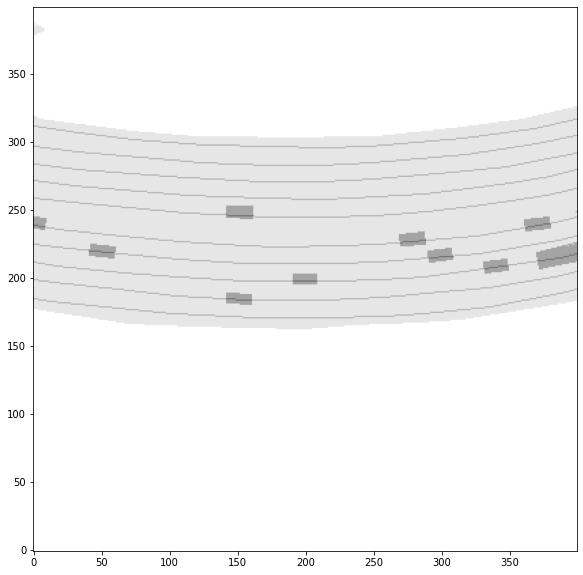

In [24]:
# Plot vehicles occupancy, pedestrian occupancy, lane occupancy and road polygon
plt.figure(figsize=(10, 10))
plt.imshow(data_item['feature_maps'][0], origin='lower', cmap='binary', alpha=0.7)
plt.imshow(data_item['feature_maps'][6], origin='lower', cmap='binary', alpha=0.5)
plt.imshow(data_item['feature_maps'][13], origin='lower', cmap='binary', alpha=0.2)
plt.imshow(data_item['feature_maps'][16], origin='lower', cmap='binary', alpha=0.1)

## Filtration by Tags

In [25]:
# To filter scenes by tags one should specify a filter function
# The scene tags dict has following structure:
# {
#     'day_time': one of {'kNight', 'kMorning', 'kAfternoon', 'kEvening'}
#     'season': one of {'kWinter', 'kSpring', 'kSummer', 'kAutumn'}
#     'track': one of {'Moscow' , 'Skolkovo', 'Innopolis', 'AnnArbor', 'Modiin', 'TelAviv'}
#     'sun_phase': one of {'kAstronomicalNight', 'kTwilight', 'kDaylight'}
#     'precipitation': one of {'kNoPrecipitation', 'kRain', 'kSleet', 'kSnow'}
# }
# Full description of protobuf message is available at tags.proto file in sources


def filter_scene(scene_tags_dict):
    if scene_tags_dict['track'] == 'AnnArbor' and scene_tags_dict['precipitation'] == 'kRain':
        return True
    else:
        return False

In [26]:
# Trajectory tags list can include any number of the following non-mutually exclusive tags.
# [
#     'kMoveLeft', 'kMoveRight', 'kMoveForward', 'kMoveBack',
#     'kAcceleration', 'kDeceleration', 'kUniform',
#     'kStopping', 'kStarting', 'kStationary'
# ]


def filter_trajectory(trajectory_tags_list):
    if 'kMoveRight' in trajectory_tags_list:
        return True
    else:
        return False

In [27]:
# Let's try to filter scenes

dataset = MotionPredictionDataset(
    dataset_path=dataset_path,
    scene_tags_fpath=scene_tags_fpath,
    feature_producer=renderer,
    transform_ground_truth_to_agent_frame=True,
    scene_tags_filter=filter_scene,
    trajectory_tags_filter=filter_trajectory,
)

950/500000 scenes fit the filter criteria.


In [28]:
# Rainy Ann-Arbor is a pretty rare occasion
dataset.num_scenes

950

In [29]:
dataset_iter = iter(dataset)

In [30]:
for i in range(10):
    data_item = next(dataset_iter)

In [35]:
transformed_gt = transform_2d_points(data_item['ground_truth_trajectory'], renderer.to_feature_map_tf)
transformed_gt = np.round(transformed_gt - 0.5).astype(np.int32)

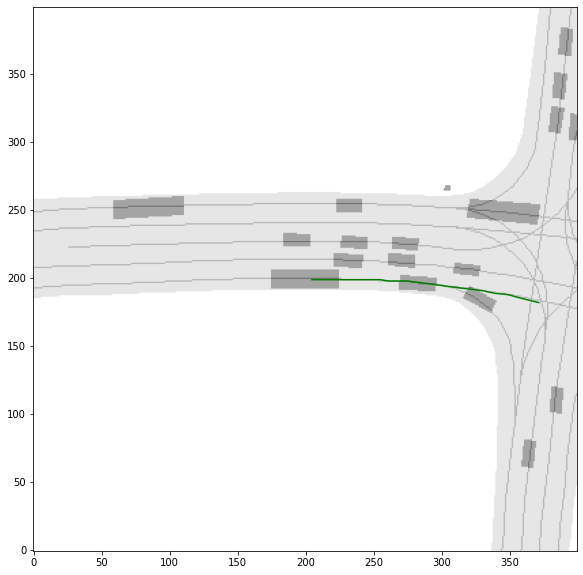

In [37]:
plt.figure(figsize=(10, 10))
plt.imshow(data_item['feature_maps'][0], origin='lower', cmap='binary', alpha=0.7)
plt.imshow(data_item['feature_maps'][6], origin='lower', cmap='binary', alpha=0.5)
plt.imshow(data_item['feature_maps'][13], origin='lower', cmap='binary', alpha=0.2)
plt.imshow(data_item['feature_maps'][16], origin='lower', cmap='binary', alpha=0.1)
ax = plt.gca()
ax.add_collection(mc.LineCollection([transformed_gt], color='green'))

## Prerendered Dataset

In [38]:
# We use raw protobuf dataset here to extract ground truth trajectories
prerenderer_dataset = MotionPredictionDataset(
    dataset_path='/path/to/datasets/train_pb/',
    scene_tags_fpath='/path/to/datasets/train_tags.txt',
    prerendered_dataset_path='/path/to/datasets/train_rendered/',
)

500000/500000 scenes fit the filter criteria.


In [39]:
dataset_iter = iter(prerenderer_dataset)

In [40]:
for i in range(10):
    item = next(dataset_iter)

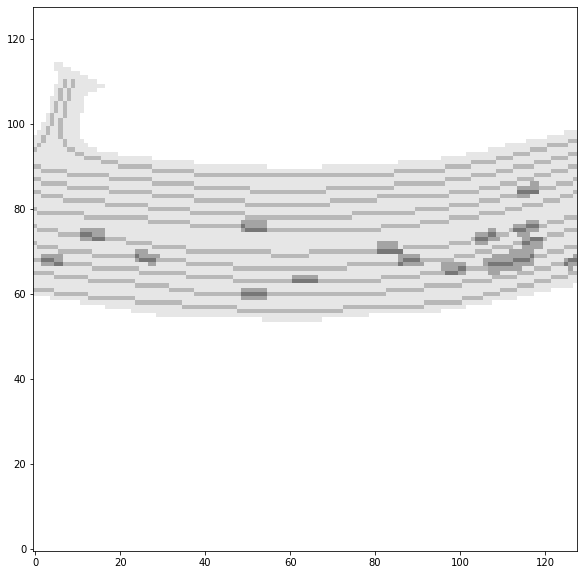

In [41]:
plt.figure(figsize=(10, 10))
plt.imshow(item['prerendered_feature_map'][0], origin='lower', cmap='binary', alpha=0.7)
plt.imshow(item['prerendered_feature_map'][6], origin='lower', cmap='binary', alpha=0.5)
plt.imshow(item['prerendered_feature_map'][13], origin='lower', cmap='binary', alpha=0.2)
plt.imshow(item['prerendered_feature_map'][16], origin='lower', cmap='binary', alpha=0.1)

## Model Evaluation

In [5]:
# We will evaluate on the two validation datasets:
# In-Domain (Moscow)
# Distributionally Shifted (Skolkovo, Modiin, and Innopolis)

def filter_moscow_no_precipitation_data(scene_tags_dict):
    if (scene_tags_dict['track'] == 'Moscow' and
            scene_tags_dict['precipitation'] == 'kNoPrecipitation'):
        return True
    else:
        return False

def filter_ood_validation_data(scene_tags_dict):
    if (scene_tags_dict['track'] in ['Skolkovo', 'Modiin', 'Innopolis'] and
        scene_tags_dict[
            'precipitation'] in ['kNoPrecipitation', 'kRain', 'kSnow']):
        return True
    else:
        return False

In [6]:
validation_dataset_path = '/path/to/datasets/validation_pb/'
prerendered_dataset_path = '/path/to/dataset/validation_rendered/'
scene_tags_fpath = '//path/to/datasets/validation_tags.txt'

In [7]:
# Load in validation datasets
# We provide both the pre-rendered dataset paths and protobuf paths, 
# to speed up dataloading.

moscow_validation_dataset = MotionPredictionDataset(
    dataset_path=validation_dataset_path,
    prerendered_dataset_path=prerendered_dataset_path,
    scene_tags_fpath=scene_tags_fpath,
    scene_tags_filter=filter_moscow_no_precipitation_data,
)

ood_validation_dataset = MotionPredictionDataset(
    dataset_path=validation_dataset_path,
    prerendered_dataset_path=prerendered_dataset_path,
    scene_tags_fpath=scene_tags_fpath,
    scene_tags_filter=filter_ood_validation_data,
)

27036/50000 scenes fit the filter criteria.
9569/50000 scenes fit the filter criteria.


In [ ]:
from sdc.config import build_parser

parser = build_parser()
args = parser.parse_args('')

def ipynb_patch_args(args):
    args.dir_checkpoint = '/path/to/model_checkpoints'

    # Backbone model details
    # Deep Imitative Model: 
    # MobileNetv2 feature encoder, autoregressive flow decoder
    args.model_name = 'dim'
    args.model_dim_hidden = 512
    args.exp_device = 'cuda:0'
    
    # Used in scoring generated trajectories and obtaining 
    # per-plan/per-scene confidence scores.
    # See 
    #   `sdc.oatomobile.torch.baselines.robust_imitative_planning.py` 
    # for details.
    args.rip_per_plan_algorithm = 'LQ'
    args.rip_per_scene_algorithm = 'LQ'
    
    # Number of ensemble members
    args.rip_k = 5
    
    # Data loading
    # https://pytorch.org/docs/stable/data.html
    args.exp_batch_size = 256
    args.data_num_workers = 10
    args.data_prefetch_factor = 2
    
    # Cache loss metrics here
    args.dir_metrics = '/path/to/metrics'

    # If enabled, will compute retention scores with 0 loss on all
    # non-retained points. This is analogous to the AV agent working
    # with a human that can perform optimally when given control.
    args.metrics_retention_use_oracle = True

    return args

c = ipynb_patch_args(args)

In [ ]:
from sdc.oatomobile.torch.baselines import init_rip
from sdc.oatomobile.torch.baselines.robust_imitative_planning import \
    load_rip_checkpoints
from typing import Mapping
from sdc.metrics import SDCLoss
from typing import Optional

class Model:
    def __init__(self, c):
        self.c = c
    
        # Initialize torch hub dir to cache MobileNetV2
        torch.hub.set_dir(f'{c.dir_checkpoint}/torch_hub')
        
    def load(self):
        model, self.full_model_name, _, _ = init_rip(c=self.c)
        checkpoint_dir = f'{c.dir_checkpoint}/{self.full_model_name}'
        self.model = load_rip_checkpoints(
            model=model, device=c.exp_device, k=c.rip_k,
            checkpoint_dir=checkpoint_dir)
        
    
    def predict(self, batch: Mapping[str, torch.Tensor], sdc_loss: Optional[SDCLoss]):
        """
        Args:
            batch: Mapping[str, torch.Tensor], with 'feature_maps' key/value

        Returns:
            Sequence of dicts. Each has the following structure:
                {
                    predictions_list: Sequence[np.ndarray],
                    plan_confidence_scores_list: Sequence[np.ndarray],
                    pred_request_confidence_score: float,
                }
        """
        self.model.eval()
        with torch.no_grad():
            predictions, plan_confidence_scores, pred_request_confidence_scores = (
                self.model(**batch))
            
        predictions = predictions.detach().cpu().numpy()
        plan_confidence_scores = plan_confidence_scores.detach().cpu().numpy()
        pred_request_confidence_scores = pred_request_confidence_scores.detach().cpu().numpy()
        
        if sdc_loss is not None:
            ground_truth = batch['ground_truth_trajectory'].detach().cpu().numpy()
            sdc_loss.cache_batch_losses(
                predictions_list=predictions,
                ground_truth_batch=ground_truth,
                plan_confidence_scores_list=plan_confidence_scores,
                pred_request_confidence_scores=pred_request_confidence_scores)
        
        return [
            {
                'predictions_list': predictions[i],
                'plan_confidence_scores_list': plan_confidence_scores[i],
                'pred_request_confidence_score':
                    pred_request_confidence_scores[i]
            } for i in range(predictions.shape[0])]

# Initialize and load ensemble of k models from checkpoints
# On first run, will fail and create a directory where checkpoints
# should be placed.
model = Model(c=c)
model.load()

In [7]:
# Init dataloader
dataloader_kwargs = {
    'batch_size': c.exp_batch_size,
    'num_workers': c.data_num_workers,
    'prefetch_factor': c.data_prefetch_factor,
    'pin_memory': True
}

print(f'Building dataloaders with kwargs {dataloader_kwargs}.')
moscow_validation_dataloader = torch.utils.data.DataLoader(moscow_validation_dataset, **dataloader_kwargs)
ood_validation_dataloader = torch.utils.data.DataLoader(ood_validation_dataset, **dataloader_kwargs)

Building dataloaders with kwargs {'batch_size': 256, 'num_workers': 10, 'prefetch_factor': 2, 'pin_memory': True}.


In [8]:
from ysdc_dataset_api.evaluation import Submission, object_prediction_from_model_output, save_submission_proto
from sdc.oatomobile.torch.baselines import batch_transform
import tqdm.notebook as tqdm
from functools import partial

In [9]:
# Init object for caching/computing loss and metrics.
sdc_loss = SDCLoss(full_model_name=model.full_model_name, c=c)

In [ ]:
# Caches metrics here
sdc_loss.metrics_dir

### Produce a Submission Protobuf and Cache Per-Batch Losses

In [ ]:
submission = Submission()

batch_cast = partial(
    batch_transform, device=c.exp_device, downsample_hw=None,
    data_use_prerendered=True)

dataset_key_to_loss_dict = {}

for dataset_key, is_ood, dataloader in zip(
    ['ood_validation', 'moscow_validation'], 
    [True, False], 
    [ood_validation_dataloader, moscow_validation_dataloader]):
    for batch_id, batch in enumerate(tqdm.tqdm(dataloader)):
        batch = batch_cast(batch)
        batch_output = model.predict(batch, sdc_loss)

        for i, data_item_output in enumerate(batch_output):
            proto = object_prediction_from_model_output(
                track_id=batch['track_id'][i],
                scene_id=batch['scene_id'][i],
                model_output=data_item_output,
                is_ood=is_ood)

            submission.predictions.append(proto)
            
    dataset_key_to_loss_dict[dataset_key] = sdc_loss.evaluate_dataset_losses(dataset_key)

In [ ]:
# First, let's write out a submission protobuf (as one should submit for the competition).
save_submission_proto('dev_moscow_and_ood_submission.pb', submission=submission)

In [ ]:
# Can check that things were written correctly as follows:
from ysdc_dataset_api.evaluation.utils import load_submission_proto
new_sub = load_submission_proto('dev_moscow_and_ood_submission.pb')
len(new_sub.predictions)

Next, let's check losses / plot some retention curves for our dev datasets and various metrics.

In [ ]:
from pprint import pprint

# We have all our aggregate losses stored.

# Print the f_beta metrics.
pprint({key: value for key, value in dataset_key_to_loss_dict['ood_validation'].items() if 'retain_scene' not in key})

In [ ]:
# We have written out results for retention plots to the metrics path.
sdc_loss.metrics_dir

moscow__test - Use Oracle True - minFDE


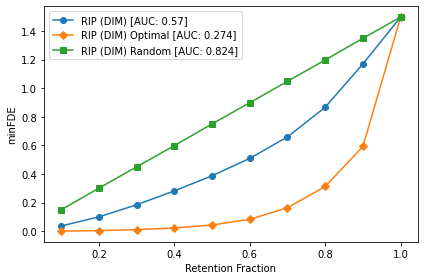

moscow__test - Use Oracle True - avgADE


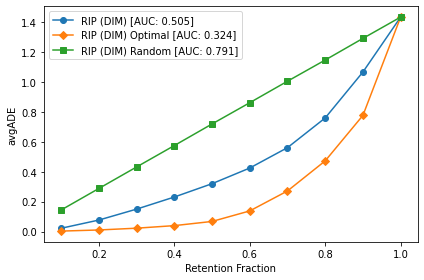

moscow__test - Use Oracle True - minADE


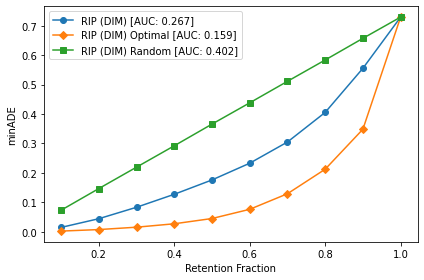

moscow__test - Use Oracle True - weightedADE


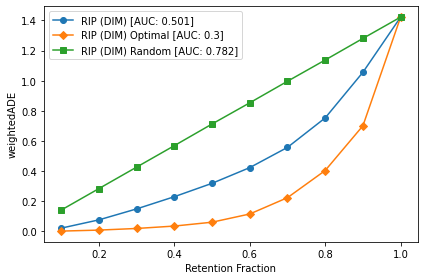

moscow__test - Use Oracle True - weightedFDE


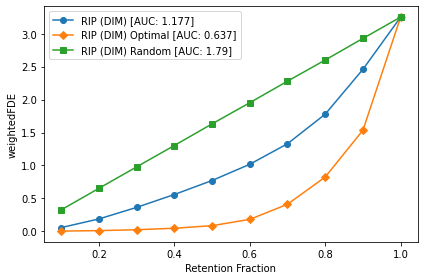

moscow__test - Use Oracle True - top1ADE


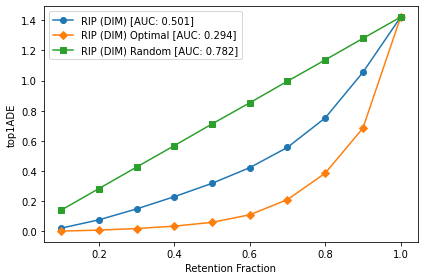

moscow__test - Use Oracle True - avgFDE


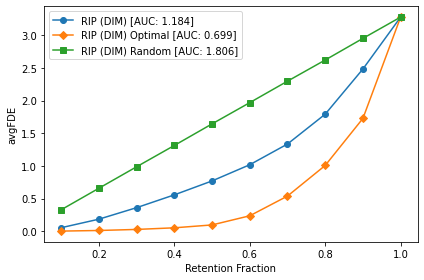

moscow__test - Use Oracle True - top1FDE


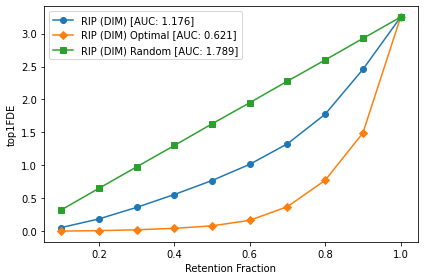

moscow__validation - Use Oracle True - minFDE


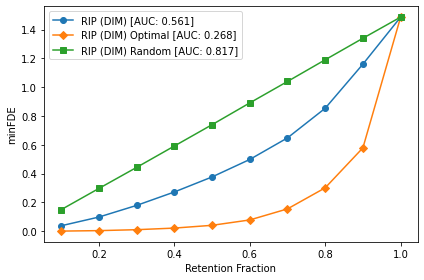

moscow__validation - Use Oracle True - avgADE


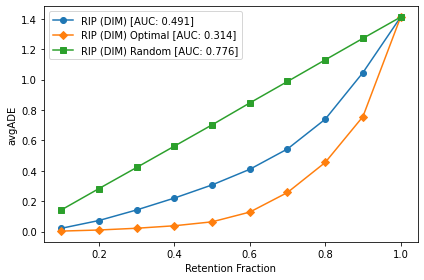

moscow__validation - Use Oracle True - minADE


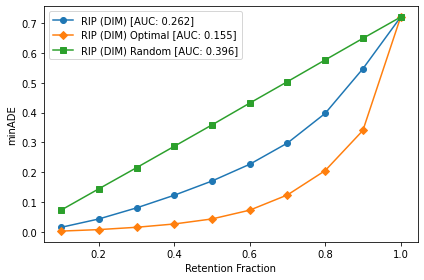

moscow__validation - Use Oracle True - weightedADE


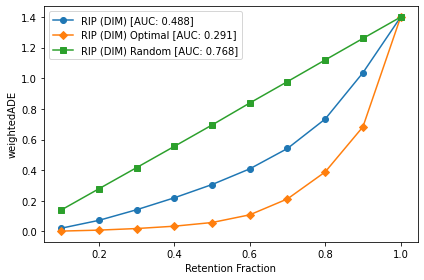

moscow__validation - Use Oracle True - weightedFDE


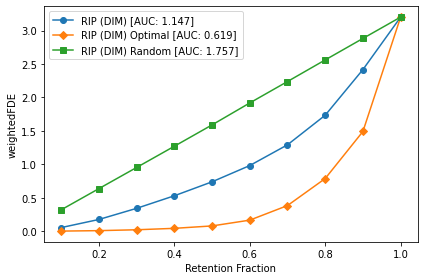

moscow__validation - Use Oracle True - top1ADE


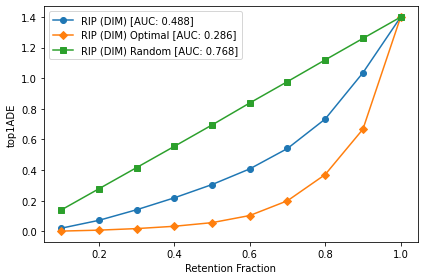

moscow__validation - Use Oracle True - avgFDE


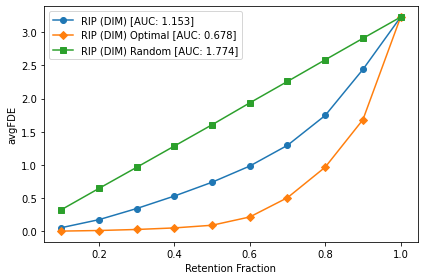

moscow__validation - Use Oracle True - top1FDE


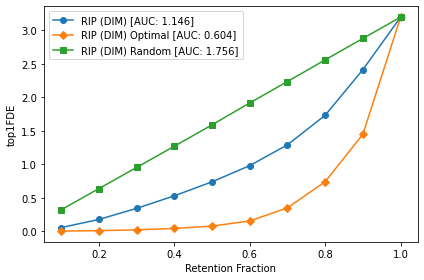

moscow_precip__test - Use Oracle True - minFDE


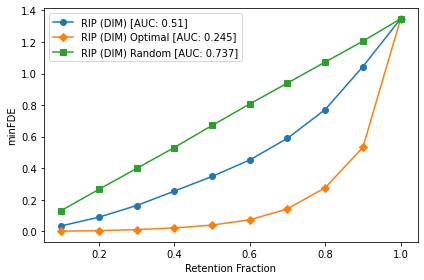

moscow_precip__test - Use Oracle True - avgADE


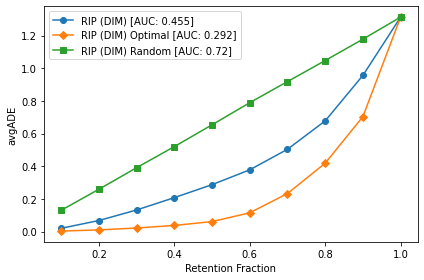

moscow_precip__test - Use Oracle True - minADE


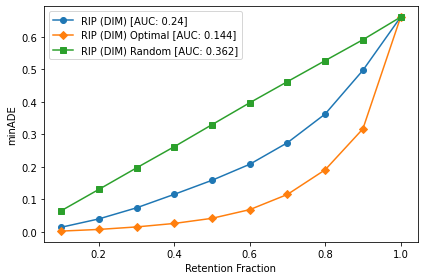

moscow_precip__test - Use Oracle True - weightedADE


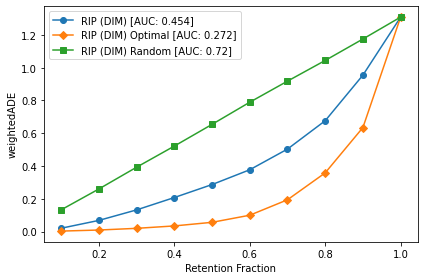

moscow_precip__test - Use Oracle True - weightedFDE


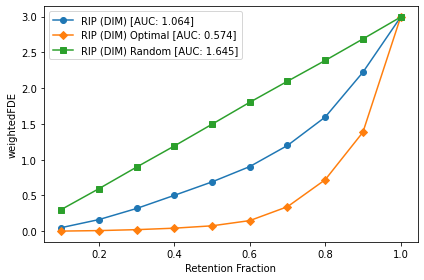

moscow_precip__test - Use Oracle True - top1ADE


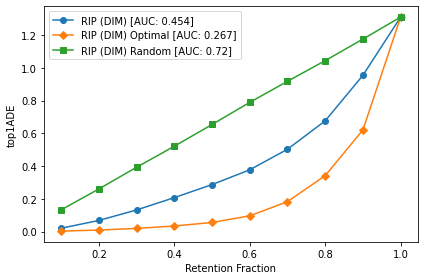

moscow_precip__test - Use Oracle True - avgFDE


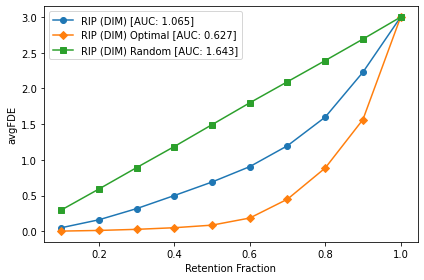

moscow_precip__test - Use Oracle True - top1FDE


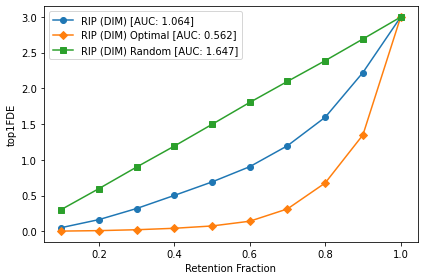

ood__test - Use Oracle True - minFDE


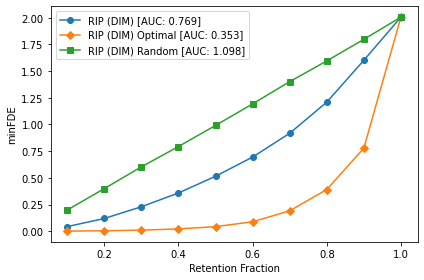

ood__test - Use Oracle True - avgADE


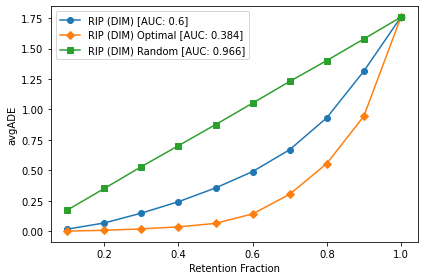

ood__test - Use Oracle True - minADE


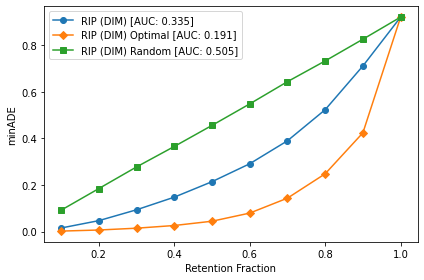

ood__test - Use Oracle True - weightedADE


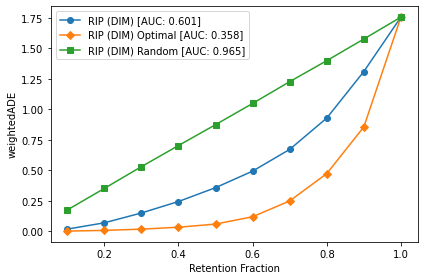

ood__test - Use Oracle True - weightedFDE


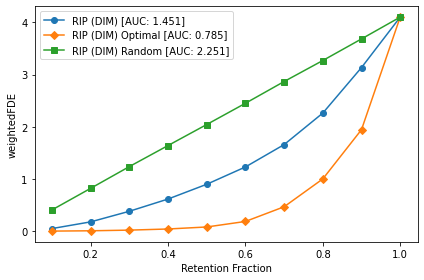

ood__test - Use Oracle True - top1ADE


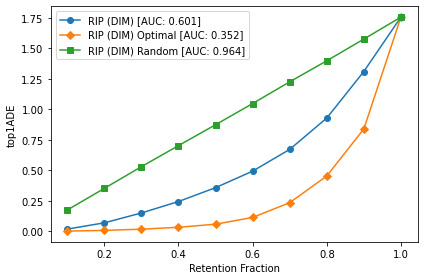

ood__test - Use Oracle True - avgFDE


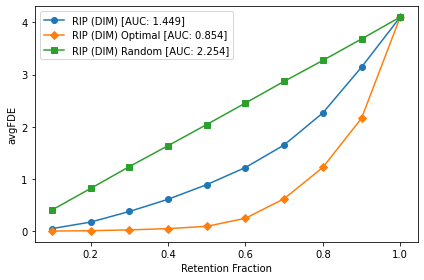

ood__test - Use Oracle True - top1FDE


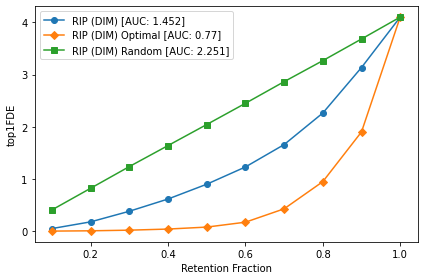

ood__validation - Use Oracle True - minFDE


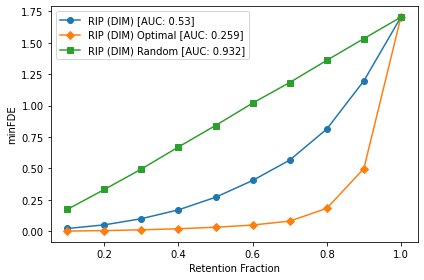

ood__validation - Use Oracle True - avgADE


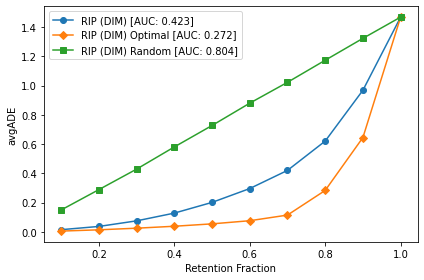

ood__validation - Use Oracle True - minADE


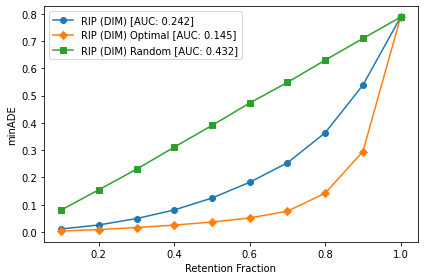

ood__validation - Use Oracle True - weightedADE


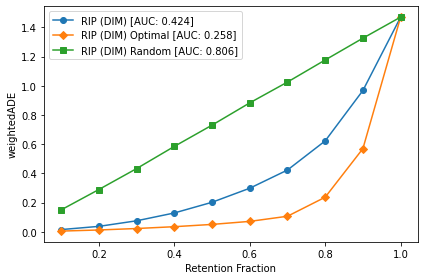

ood__validation - Use Oracle True - weightedFDE


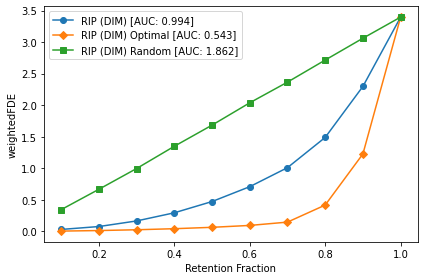

ood__validation - Use Oracle True - top1ADE


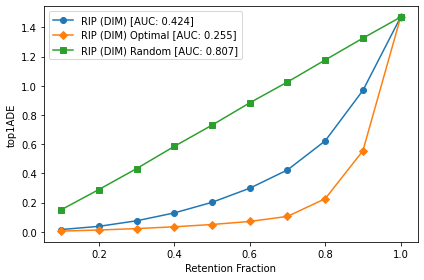

ood__validation - Use Oracle True - avgFDE


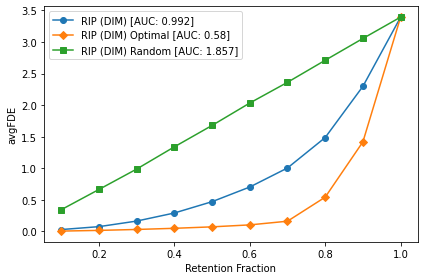

ood__validation - Use Oracle True - top1FDE


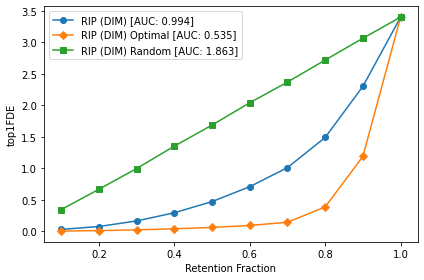

ood_validation - Use Oracle True - minFDE


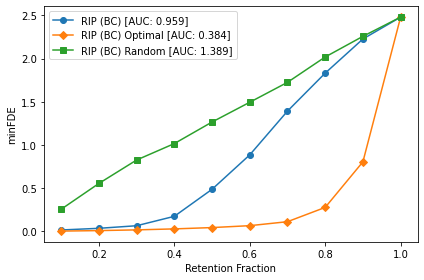

ood_validation - Use Oracle True - avgADE


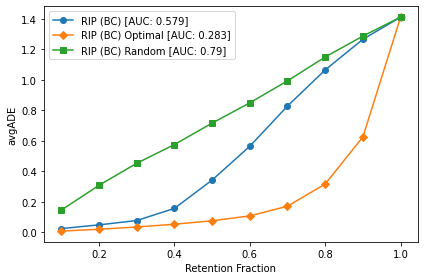

ood_validation - Use Oracle True - minADE


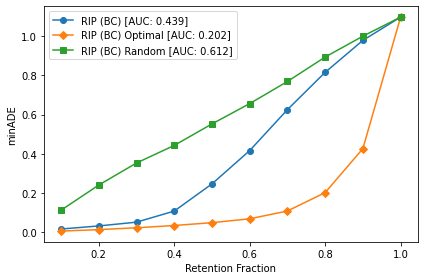

ood_validation - Use Oracle True - weightedADE


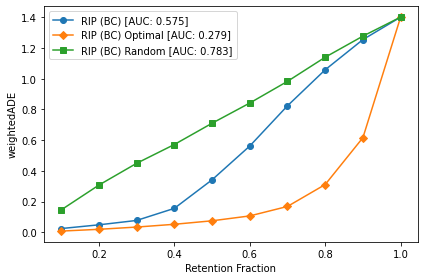

ood_validation - Use Oracle True - weightedFDE


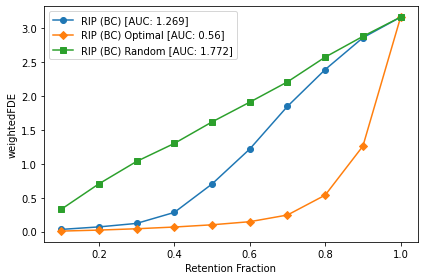

ood_validation - Use Oracle True - top1ADE


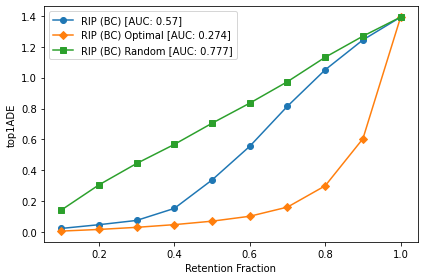

ood_validation - Use Oracle True - avgFDE


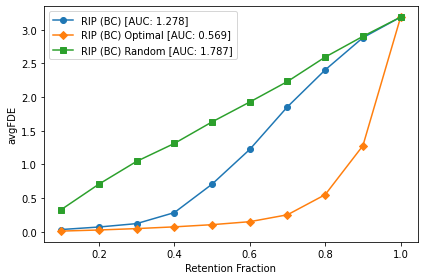

ood_validation - Use Oracle True - top1FDE


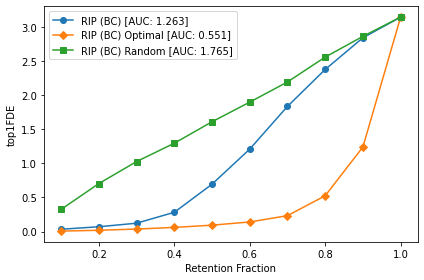

In [13]:
from plot_retention_curves import plot_retention_score_results

# Retention plots: 
# These are on our various metrics -- e.g., top1ADE, weightedFDE, etc. with 
# retention using the per--prediction request confidence scores.
# We also report baselines with 
#     * Optimal uncertainty calibration i.e., uncertainty sorted by ground truth error
#     * Random uncertainty, i.e., an uninformative ranking
# Specify a plot directory to save all plots as PDFs, pass plot_dir=None to print out plots in ipynb.
# See README for more information on retention plots.
plot_retention_score_results(
    results_dir='/path/to/metrics_dir',
    plot_dir=None,
    model_name=None)

In [ ]:
# For retention on the fbeta plots, see the analyze_dataset_metadata.ipynb example,
# in which we use cached predictions and loss values to consider various thresholds of acceptability,
# i.e., what is considered a successful or failed prediction.